In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import tarfile
import collections
import string

In [ ]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
r = requests.get(url)
with open("stack_overflow_16k.tar.gz", "wb") as file:
  file.write(r.content)
tar = tarfile.open("stack_overflow_16k.tar.gz")
tar.extractall()

In [ ]:
def tokenize(data, max_words=1000):
  words = []
  for question in data:
    for word in question.split():
      words.append(word)
  words = collections.Counter(words)
  words = sorted(words.items(), key=lambda item: item[1], reverse=True)
  tokens = {}
  t = 1
  for word, _ in words:
    punctuation = all([True if char in string.punctuation else False for char in word])
    if t > max_words:
      break
    if not punctuation:
      tokens[word] = t
      t += 1 
  return tokens

def text_to_tokens(tokens, text_data, sequence_len=325):
  new_data = []
  for question in text_data:
    tokens_list = list(map(lambda word: tokens[word] if word in tokens else 0, question.split()))
    if len(tokens_list) > sequence_len:
      #If greater than sequence_len truncate
      new_data.append(tokens_list[:sequence_len])
    else:
      #If less than sequence_len pad beginning with zeros
      new_data.append([0 for _ in range(sequence_len-len(tokens_list))] + tokens_list)
  return new_data

def read_data(data_dir):
  data = []
  labels = []
  tags = {'csharp' : 0, 'java' : 1, 'javascript' : 2, 'python' : 3}
  for tag in tags:
    folder = os.path.join(data_dir, tag)
    for text_file in os.listdir(folder):
      with open(os.path.join(folder, text_file), 'rb') as f:
        question = f.read().decode('utf-8')
        data.append(question)
        labels.append(tags[tag])
  return data, labels

def get_dataset(data_dir):
  data, labels = read_data(data_dir)
  tokens = tokenize(read_data('train')[0] if data_dir == 'test' else data)
  data = text_to_tokens(tokens, data)
  return np.array(data), np.array(labels), len(tokens)

x_train, y_train, vocab_size = get_dataset('train')
x_test, y_test, _ = get_dataset('test')

In [ ]:
class LSTM(Model):
  def __init__(self, vocab_size, embedding_dim, num_hidden):
    super().__init__()
    self.embedding = layers.Embedding(vocab_size, embedding_dim,
                                      embeddings_regularizer=tf.keras.regularizers.l2(1e-4))
    self.lstm = layers.LSTM(num_hidden,
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    self.prediction = layers.Dense(4)
  
  def call(self, inputs):
    embeddings = self.embedding(inputs)
    lstm_out = self.lstm(embeddings)
    outputs = self.prediction(lstm_out)
    return outputs

model = LSTM(vocab_size+1, 10, 32)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10
125/125 [==============================] - 23s 163ms/step - loss: 1.3471 - accuracy: 0.3352 - val_loss: 1.1887 - val_accuracy: 0.4326
Epoch 2/10
125/125 [==============================] - 19s 154ms/step - loss: 1.3231 - accuracy: 0.3644 - val_loss: 1.2148 - val_accuracy: 0.3938
Epoch 3/10
125/125 [==============================] - 20s 162ms/step - loss: 1.2245 - accuracy: 0.4121 - val_loss: 1.1321 - val_accuracy: 0.4699
Epoch 4/10
125/125 [==============================] - 20s 157ms/step - loss: 1.1279 - accuracy: 0.4927 - val_loss: 1.4323 - val_accuracy: 0.3627
Epoch 5/10
125/125 [==============================] - 21s 165ms/step - loss: 1.1561 - accuracy: 0.4431 - val_loss: 1.1639 - val_accuracy: 0.4481
Epoch 6/10
125/125 [==============================] - 20s 162ms/step - loss: 1.0837 - accuracy: 0.5098 - val_loss: 1.0511 - val_accuracy: 0.5491
Epoch 7/10
125/125 [==============================] - 21s 169ms/step - loss: 0.9069 - accuracy: 0.6419 - val_loss: 0.8348 - val_ac

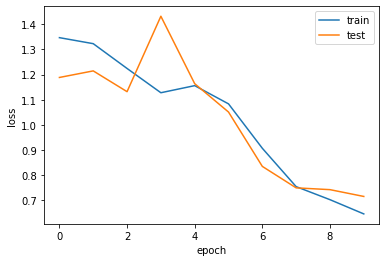

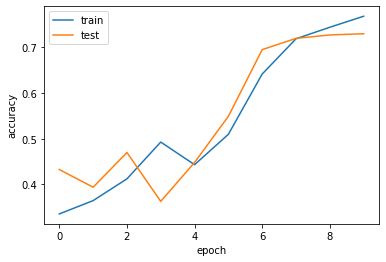

In [ ]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()